In [ ]:
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

In [ ]:
!pip install konlpy
!pip install git+https://github.com/kakaobrain/pororo.git
!pip install pykrx 
!pip install jamo
!pip install -U Finance-DataReader

In [ ]:
! git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git

In [ ]:
cd Mecab-ko-for-Google-Colab

In [ ]:
!bash install_mecab-ko_on_colab_light_220429.sh

In [ ]:
cd ../

In [ ]:
# 코스피 코스닥 상장 기업 정보 리스트 생성
from pykrx import stock
import pandas as pd
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
import platform
from datetime import datetime, timedelta

today = datetime.today().strftime("%Y%m%d")
last_week = (datetime.today() - timedelta(7)).strftime("%Y%m%d")

KOSDAQ = stock.get_market_ticker_list(market="KOSDAQ")
KOSPI = stock.get_market_ticker_list(market="KOSPI")

def return_name():
    Company = []

    for ticker in KOSDAQ:
        Value =stock.get_market_ticker_name(ticker)
        Company.append([Value,ticker,"KOSDAQ"]) # 기업명, 종목번호, 코스닥 리스트에 추가
      
    for ticker in KOSPI:
        Value =stock.get_market_ticker_name(ticker)
        Company.append([Value,ticker,"KOSPI"]) # 기업명, 종목번호, 코스닥 리스트에 추가
 
    return Company;

In [ ]:
# 종성 여부 체크
from jamo import h2j, j2hcj

def get_jongsung_TF(text):
  sample_text_list = list(text)
  last_word = sample_text_list[-1]
  last_word_jamo_list = list(j2hcj(h2j(last_word)))
  last_jamo = last_word_jamo_list[-1]

  jongsung_TF = "T"

  if last_jamo in ['ㅏ','ㅑ','ㅓ','ㅕ','ㅗ','ㅛ','ㅜ','ㅠ','ㅡ','ㅣ','ㅘ','ㅚ','ㅙ','ㅝ','ㅞ','ㅢ','ㅐ','ㅔ','ㅟ','ㅖ','ㅒ'] :
    jongsung_TF = "F"

  return jongsung_TF

In [ ]:
# 사용자 사전 적용 : 고유명사 구분하기 위해 코스피, 코스닥 상장 기업들 사용자 사전에 추가
with open("./mecab-ko-dic-2.1.1-20180720/user-dic/nnp.csv",'r',encoding='utf-8') as f:
  file_data = f.readlines()
Company = return_name()
for c in Company:
  jongsung_TF = get_jongsung_TF(c[0])
  line = '{},,,,NNP,*,{},{},*,*,*,*,*\n'.format(c[0], jongsung_TF, c[0])
  file_data.append(line)
with open("./mecab-ko-dic-2.1.1-20180720/user-dic/nnp.csv",'w',encoding='utf-8') as f:
  for line in file_data:
    f.write(line)

In [ ]:
# 뉴스 요약 및 기업 정보 추출
from bs4 import BeautifulSoup
import requests
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from konlpy.tag import Mecab
from pykrx import stock
import pandas as pd
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
import platform
from datetime import datetime, timedelta
from pororo import Pororo

today = datetime.today().strftime("%Y%m%d")
last_week = (datetime.today() - timedelta(7)).strftime("%Y%m%d")

bullet_summ = Pororo(task="text_summarization", lang="ko", model="bullet")
abs_summ = Pororo(task="text_summarization", lang="ko", model="abstractive")

dataset1 = Pororo(task='sentiment',model='brainbert.base.ko.shopping', lang='ko') # 네이버 쇼핑 데이터셋
dataset2 = Pororo(task='sentiment', model='brainbert.base.ko.nsmc', lang='ko') # 네이버 영화 리뷰 데이터셋


def summerize_news(url, Company):
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.88 Safari/537.36"}
    req = requests.get(url, headers=headers)
    soup = BeautifulSoup(req.text, 'html.parser')
    body = soup.find_all(id='dic_area')
    if len(body) > 0:
        text = body[0].text
        output_bullet = bullet_summ(text,
                                    beam=5,
                                    len_penalty=0.6,
                                    no_repeat_ngram_size=3,
                                    top_k=50,
                                    top_p=0.7)
        summary_output = abs_summ(text,
                                  beam=5,
                                  len_penalty=0.6,
                                  no_repeat_ngram_size=3,
                                  top_k=50,
                                  top_p=0.7
                                  )
      
        mecab = Mecab()
        noun = mecab.nouns(summary_output) # 명사만 추출
        pos = mecab.pos(summary_output) # 형태소 분석
        removelist = ['JKS', 'JKC', 'JKG', 'JKO', 'JKB', 'JKV', 'JKQ', 'JX', 'JC', 'EF'] # 조사 품사 리스트 - 제거할 품사
        resultlist = []
        for p in pos :
          if len(p[0])>1 and p[1] not in removelist : # 토큰의 길이가 1 초과이고 조사가 아니면 감정 분석에 활용할 토큰이므로 리스트에 추가
            resultlist.append(p)
        #print(pos)
        #print(resultlist)

        company_name = []
        for c in Company :
          company_name.append(c[0]);

        summ = "[주요] \n"
        for line in output_bullet:
          summ += "-"+line+"\n"
        summ += "[요약] \n"
        summ += summary_output+"\n" # 뉴스 요약본
        summ += dataset1(summary_output)
        summ += "[회사정보] \n"
        chk = False
        idx = 0
        for n in noun : # 뉴스 요약본 속 명사들 중에서 코스피, 코스닥 상장 기업명 찾기
          try :
            idx = company_name.index(n)
          except :
            chk = False
          else :
            summ += str(Company[idx])
            chk = True
            break
        if chk==False :
          summ += "null \n"
        print(summ)
        if (idx != 0):
          ticker = Company[idx][1]
          info_a = stock.get_market_ohlcv(last_week, today, ticker)
          print(info_a) #주가
          info_b = stock.get_market_cap(last_week, today, ticker)
          print(info_b) #시가총액, 거래량, 거래대금, 상장주식수 
          info_c = stock.get_exhaustion_rates_of_foreign_investment(last_week, today, ticker)
          print(info_c) #외국인 보유량 및 외국인 한도소진율
          info_d = stock.get_market_fundamental(last_week, today, ticker)
          print(info_d) #DIV/BPS/PER/EPS
          info_e = stock.get_shorting_volume_by_date(last_week, today, ticker)
          print(info_e) #공매도 현황
          info_g = fdr.DataReader(symbol=ticker, start= "2020")
          fig = plt.figure(figsize=(14, 6))
          ax = fig.add_subplot(1, 1, 1)
          ax.plot(info_g['Close'])
          ax.set_xlabel("Date")
          ax.set_ylabel(ticker)
          ax.set_title("stock price")
          plt.grid(True, axis='y')
          plt.show() #주가그래프
        return summ
    else:
        print("error")
        return "error"

In [ ]:
import time
import re
import requests
from datetime import datetime
from dateutil.relativedelta import relativedelta

# 오늘 날짜 형식화
now=datetime.now()
now=str(now)
year=now[0:4]
month=now[5:7]
day=now[8:10]
res=year+month+day

# url file에 저장 (max_page_num 바꿔주면 됨)
output_file_name=str(res)+"_url.txt"
output_file = open(output_file_name, "w", encoding="utf-8")
page_num = 1
max_page_num = 1

user_agent = "'Mozilla/5.0"
headers ={"User-Agent" : user_agent}

urls = []
while page_num<=max_page_num:
    page_url = "http://news.naver.com/main/list.nhn?sid2=258&sid1=101&mid=shm&mode=LS2D&date=" + str(res) + "&page=" + str(page_num) + ""
    response = requests.get(page_url, headers=headers)
    html = response.text
    # url 추출
    url_frags = re.findall('<a href="(.*?)"',html)
    for url_frag in url_frags:
        if "article" in url_frag:
            urls.append(url_frag)
            #print(url_frag)
    page_num+=1
urls=set(urls)
for url in urls:
    print(url, file=output_file)
time.sleep(2)
output_file.close()

# url 바탕으로 요약문 생성
# 요약문 file에 저장(테스트용으로 count로 6개만 끊어준것임)
output_file_name2=str(res)+"_summarized.txt"
output_file2 = open(output_file_name2, "w", encoding="utf-8")
count=0
for url in urls:
  if(count>20):
    break
  count=count+1
  print(summerize_news(url,return_name()), file=output_file2)
output_file2.close()
'''
# mount it
from google.colab import drive
drive.mount('/content/drive')
# copy it there
!cp "20220408_summarized.txt" /content/drive/MyDrive
!cp "20220408_url.txt" /content/drive/MyDrive
'''


[주요] 
-롯데케미칼 日지사 상무 합류
- 인수·합병 담당할 듯
[요약] 
롯데 급여 신유열씨는 2020년 일본 롯데와 일본 롯데홀딩스에 부장으로 입사해 근무했으며 최근 롯데케미칼 일본 지사에 미등기 임원으로 합류했는데, 일본 롯데, 롯데홀딩스 업무도 겸직하면서 향후 인수·합병(M&A) 업무를 담당할 것으로 전해졌다.
Positive[회사정보] 
['롯데케미칼', '011170', 'KOSPI']
                시가      고가      저가      종가     거래량
날짜                                                
2022-05-09  196000  196500  191000  192000   70139
2022-05-10  191000  191500  186000  189500  107593
2022-05-11  187000  192500  187000  191500   92096
2022-05-12  189500  192000  187000  188000  103716
2022-05-13  186500  192500  186500  192500   58307
2022-05-16  193000  194000  190000  192500   54645
                     시가총액     거래량         거래대금     상장주식수
날짜                                                      
2022-05-09  6580880448000   70139  13526781500  34275419
2022-05-10  6495191900500  107593  20434978000  34275419
2022-05-11  6563742738500   92096  17471031000  34275419
2022-05-12  6443778772000  103716  19579649000  34275419
2022-05-13  6598018157500

[Korean Sentence Splitter]: findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.
[Korean Sentence Splitter]: findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


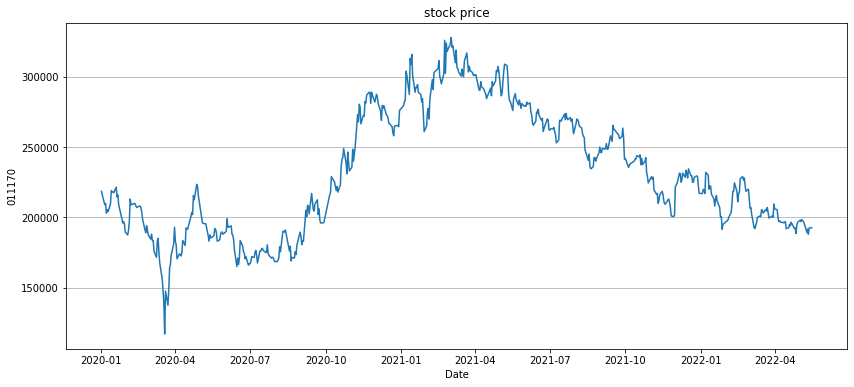

"[주요] \n-롯데케미칼 日지사 상무 합류\n- 인수·합병 담당할 듯\n[요약] \n롯데 급여 신유열씨는 2020년 일본 롯데와 일본 롯데홀딩스에 부장으로 입사해 근무했으며 최근 롯데케미칼 일본 지사에 미등기 임원으로 합류했는데, 일본 롯데, 롯데홀딩스 업무도 겸직하면서 향후 인수·합병(M&A) 업무를 담당할 것으로 전해졌다.\nPositive[회사정보] \n['롯데케미칼', '011170', 'KOSPI']"

In [ ]:
summerize_news('https://n.news.naver.com/mnews/article/277/0005088162?sid=101', return_name())